In [1]:
# !pip install numpy==1.26.4
# !pip install scikit-surprise
# !pip install pandas

In [2]:
import warnings
# Suppress DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
from collections import defaultdict

## Loading Dataset

In [4]:
data_path = '/Users/rahil/Documents/Online_Retail_Recommendation_Project/data/'
# Read product data
products_df = pd.read_csv(data_path+'prod_cat_info.csv')
# Read customer profiles
customers_df = pd.read_csv(data_path+'Customer.csv')
# Read Transactions history
Transactions_df = pd.read_csv(data_path+'Transactions.csv')

# EDA and Preprocessing

In [5]:
print(products_df.head())
print(products_df.info())
print(products_df.describe())

   prod_cat_code  prod_cat  prod_sub_cat_code prod_subcat
0              1  Clothing                  4        Mens
1              1  Clothing                  1       Women
2              1  Clothing                  3        Kids
3              2  Footwear                  1        Mens
4              2  Footwear                  3       Women
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   prod_cat_code      23 non-null     int64 
 1   prod_cat           23 non-null     object
 2   prod_sub_cat_code  23 non-null     int64 
 3   prod_subcat        23 non-null     object
dtypes: int64(2), object(2)
memory usage: 864.0+ bytes
None
       prod_cat_code  prod_sub_cat_code
count      23.000000          23.000000
mean        3.739130           6.130435
std         1.711389           3.805550
min         1.000000           1.000000
25%     

/var/folders/7w/kcxvdv_n14n3rmr6yf1fp8m00000gn/T/ipykernel_73792/1029994534.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(products_df, x='prod_sub_cat_code', y='prod_cat', inner='stick', palette='Dark2')


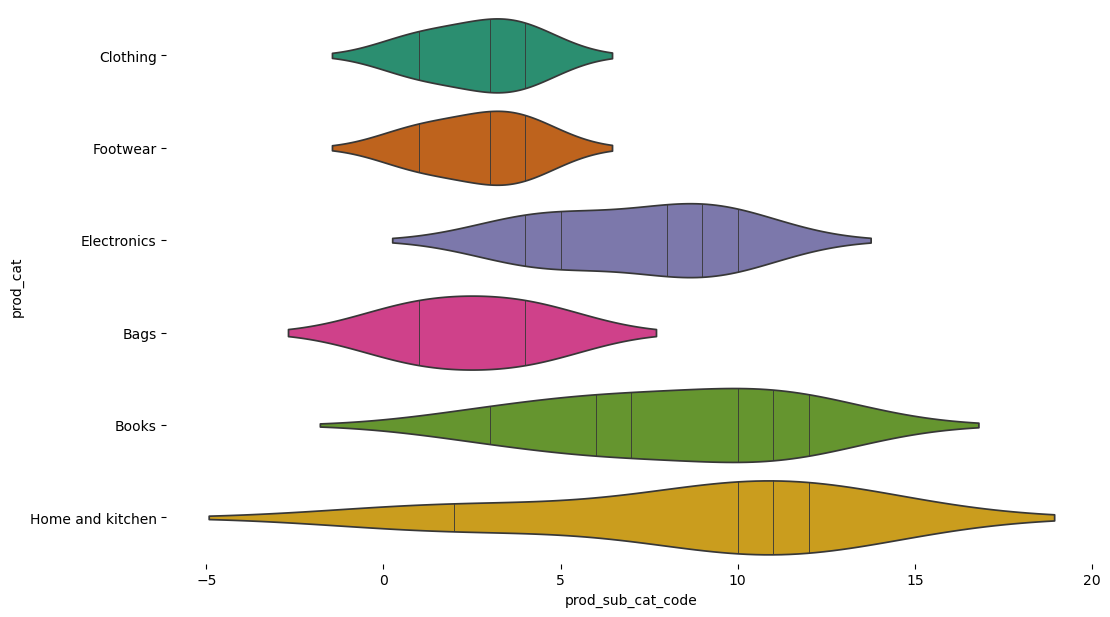

In [6]:
figsize = (12, 1.2 * len(products_df['prod_cat'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(products_df, x='prod_sub_cat_code', y='prod_cat', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [7]:
products_df.groupby('prod_cat').size()

prod_cat
Bags                2
Books               6
Clothing            3
Electronics         5
Footwear            3
Home and kitchen    4
dtype: int64

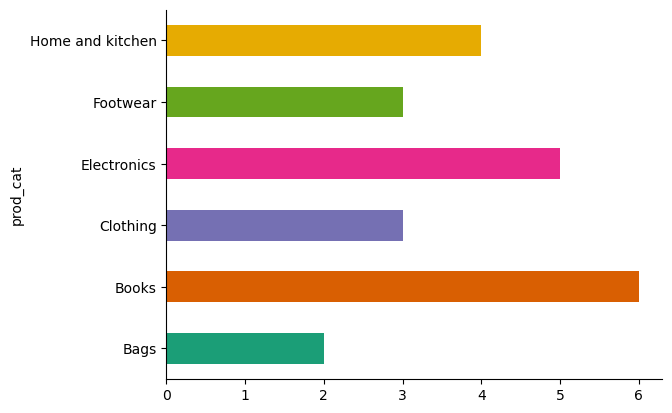

In [8]:
products_df.groupby('prod_cat').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
print(customers_df.head())
print("null value summary")
print(customers_df.isnull().sum()/len(customers_df)*100)
# customer_Id    0.000000
# DOB            0.000000
# Gender         0.035417
# city_code      0.035417
# dtype: float64

   customer_Id         DOB Gender  city_code
0       268408  02-01-1970      M        4.0
1       269696  07-01-1970      F        8.0
2       268159  08-01-1970      F        8.0
3       270181  10-01-1970      F        2.0
4       268073  11-01-1970      M        1.0
null value summary
customer_Id    0.000000
DOB            0.000000
Gender         0.035417
city_code      0.035417
dtype: float64


## **Checking and handling missing values**

In [10]:
# Handle missing values in the 'Gender' column
customers_df['Gender'] = customers_df['Gender'].fillna(customers_df['Gender'].mode()[0])

# Handle missing values in the 'city_code' column
customers_df['city_code'] = customers_df['city_code'].fillna(customers_df['city_code'].mean())

In [11]:
customers_df.isnull().sum()/len(customers_df)*100

customer_Id    0.0
DOB            0.0
Gender         0.0
city_code      0.0
dtype: float64

In [44]:
print(customers_df.info())
print("_"*80)
print(customers_df.describe())
# 	customer_Id	city_code
# count	5647.000000	5647.000000
# mean	271037.281034	5.472631
# std	2451.261711	2.859412
# min	266783.000000	1.000000
# 25%	268912.000000	3.000000
# 50%	271028.000000	5.000000
# 75%	273180.000000	8.000000
# max	275265.000000	10.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   cust_id    5647 non-null   int64         
 1   DOB        5647 non-null   datetime64[ns]
 2   Gender     5647 non-null   object        
 3   city_code  5647 non-null   float64       
 4   Age        5647 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 220.7+ KB
None
________________________________________________________________________________
             cust_id                            DOB    city_code          Age
count    5647.000000                           5647  5647.000000  5647.000000
mean   271037.281034  1981-07-23 18:17:01.285638400     5.472631    42.980344
min    266783.000000            1970-01-02 00:00:00     1.000000    32.000000
25%    268912.000000            1975-10-19 00:00:00     3.000000    37.000000
50%   

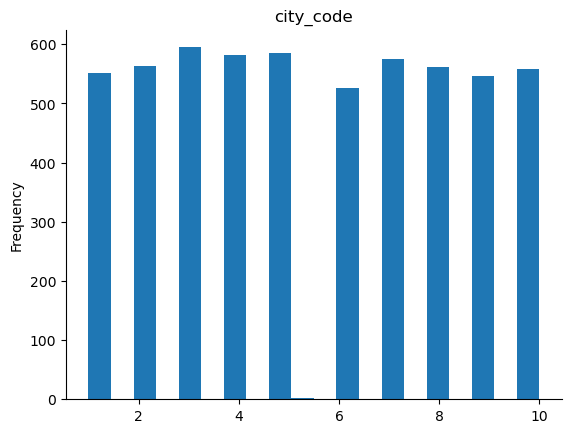

In [13]:
from matplotlib import pyplot as plt
customers_df['city_code'].plot(kind='hist', bins=20, title='city_code')
plt.gca().spines[['top', 'right',]].set_visible(False)

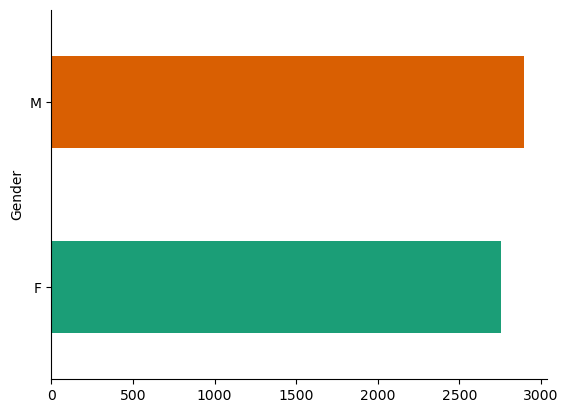

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
customers_df.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
customers_df.head()

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [16]:
# converting DOB to datetime
customers_df['DOB'] = pd.to_datetime(customers_df['DOB'], format="%d-%m-%Y")
customers_df.info()

# Calculating Age of customers
customers_df['DOB'] = pd.to_datetime(customers_df['DOB'], format="%d-%m-%Y")
customers_df['Current_date'] = datetime.datetime.now()
customers_df['Age'] = (customers_df['Current_date'] - customers_df['DOB']).dt.days // 365
customers_df.drop('Current_date', axis=1, inplace=True)
customers_df['Age'].value_counts()

# Renaming columns
Transactions_df.rename(columns={'prod_subcat_code': 'prod_sub_cat_code'}, inplace=True)
customers_df.rename(columns={'customer_Id': 'cust_id'}, inplace=True)

# Converting gender labels ['M', 'F'] ->  ['Male', 'Female']
customers_df['Gender'] = customers_df['Gender'].replace(['M', 'F'], ['Male', 'Female'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_Id  5647 non-null   int64         
 1   DOB          5647 non-null   datetime64[ns]
 2   Gender       5647 non-null   object        
 3   city_code    5647 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 176.6+ KB


In [17]:
customers_df.head()

,cust_id,DOB,Gender,city_code,Age
0,268408,1970-01-02,Male,4.0,55
1,269696,1970-01-07,Female,8.0,55
2,268159,1970-01-08,Female,8.0,55
3,270181,1970-01-10,Female,2.0,55
4,268073,1970-01-11,Male,1.0,55


In [18]:
prod_cat_mapping = dict(zip(products_df['prod_cat_code'], products_df['prod_cat']))

Transactions_df['prod_cat'] = Transactions_df['prod_cat_code'].map(prod_cat_mapping)

prod_subcat_mapping = dict(zip(products_df['prod_sub_cat_code'], products_df['prod_subcat']))

Transactions_df['prod_subcat'] = Transactions_df['prod_sub_cat_code'].map(prod_subcat_mapping)

In [19]:
Transactions_df.head()

,transaction_id,cust_id,tran_date,prod_sub_cat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,prod_cat,prod_subcat
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,Clothing,Mens
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,Electronics,Computers
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,DIY
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,Home and kitchen,Bath
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,DIY


In [20]:
# concating category and subcategory
Transactions_df['prod_cat_subcat'] = Transactions_df['prod_cat'] + ' ' + Transactions_df['prod_subcat']
Transactions_df.head()

,transaction_id,cust_id,tran_date,prod_sub_cat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,prod_cat,prod_subcat,prod_cat_subcat
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,Clothing,Mens,Clothing Mens
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,Electronics,Computers,Electronics Computers
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,DIY,Books DIY
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,Home and kitchen,Bath,Home and kitchen Bath
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,DIY,Books DIY


In [21]:
Transactions_df.describe()

,transaction_id,cust_id,prod_sub_cat_code,prod_cat_code,Qty,Rate,Tax,total_amt
count,2.305300e+04,23053.000000,23053.000000,23053.000000,23053.000000,23053.000000,23053.000000,23053.000000
mean,5.007348e+10,271021.746497,6.149091,3.763632,2.432395,636.369713,248.667192,2107.308002
std,2.898194e+10,2431.692059,3.726372,1.677016,2.268406,622.363498,187.177773,2507.561264
min,3.268991e+06,266783.000000,1.000000,1.000000,-5.000000,-1499.000000,7.350000,-8270.925000
25%,2.493864e+10,268935.000000,3.000000,2.000000,1.000000,312.000000,98.280000,762.450000
50%,5.009313e+10,270980.000000,5.000000,4.000000,3.000000,710.000000,199.080000,1754.740000
75%,7.533000e+10,273114.000000,10.000000,5.000000,4.000000,1109.000000,365.715000,3569.150000
max,9.998755e+10,275265.000000,12.000000,6.000000,5.000000,1500.000000,787.500000,8287.500000


In [22]:
print('Total unique cust_id : ',Transactions_df['cust_id'].unique().shape[0])
print('Total unique prod_cat_code : ',Transactions_df['prod_cat_code'].unique().shape[0])
print('Total unique prod_subcat_code : ',Transactions_df['prod_sub_cat_code'].unique().shape[0])

Total unique cust_id :  5506
Total unique prod_cat_code :  6
Total unique prod_subcat_code :  12


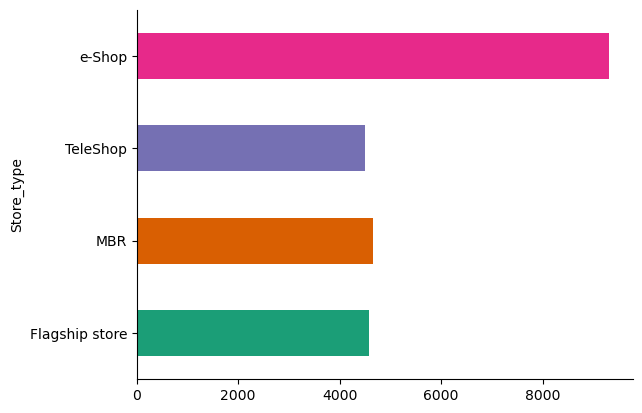

In [23]:
Transactions_df.groupby('Store_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='Qty', ylabel='Count'>

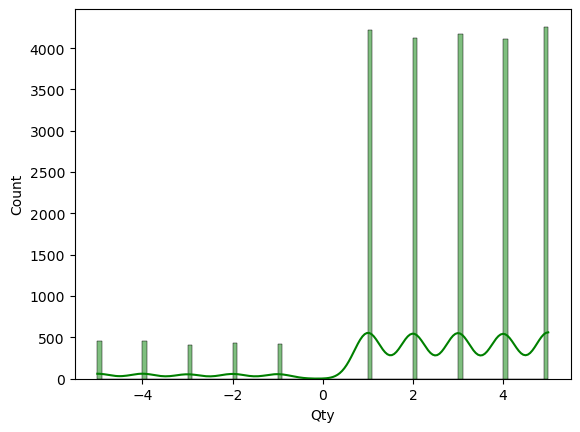

In [24]:
# prompt: Qty distibution plot

sns.histplot(Transactions_df['Qty'], color='g', bins=100, kde=True, alpha=0.5)


In [25]:
# Quntity value counts
Total_unique_Qty_value_counts=Transactions_df['Qty'].value_counts().sort_values(ascending=False)
print(Total_unique_Qty_value_counts)

Qty
 5    4259
 1    4214
 3    4174
 2    4123
 4    4106
-4     458
-5     457
-2     438
-1     419
-3     405
Name: count, dtype: int64


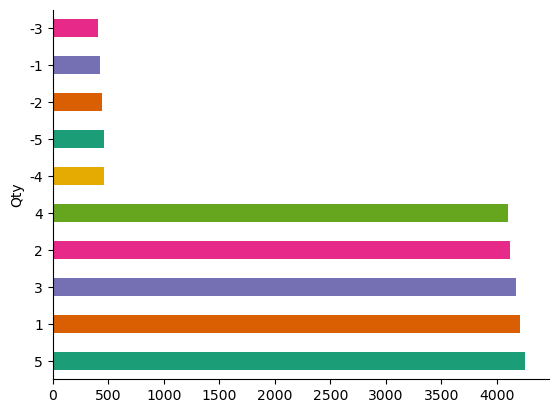

In [26]:
# Quntity bar chart
Total_unique_Qty_value_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

High sales but low returns for some products: 5 sells well with low returns, 1 & 3 similar, 2 & 4 have low sales but high returns.

In [27]:
# count of quntity total pasitive & negative
total_count = Transactions_df['Qty'].count()
positive_count = Transactions_df[Transactions_df['Qty'] > 0]['Qty'].count()
negative_count = Transactions_df[Transactions_df['Qty'] < 0]['Qty'].count()

print("Total count:", total_count)
print("Positive Quantity count:", positive_count)
print("Negative Quantity count:", negative_count)
print("Here Negative indicates the return of the product")

Total count: 23053
Positive Quantity count: 20876
Negative Quantity count: 2177
Here Negative indicates the return of the product


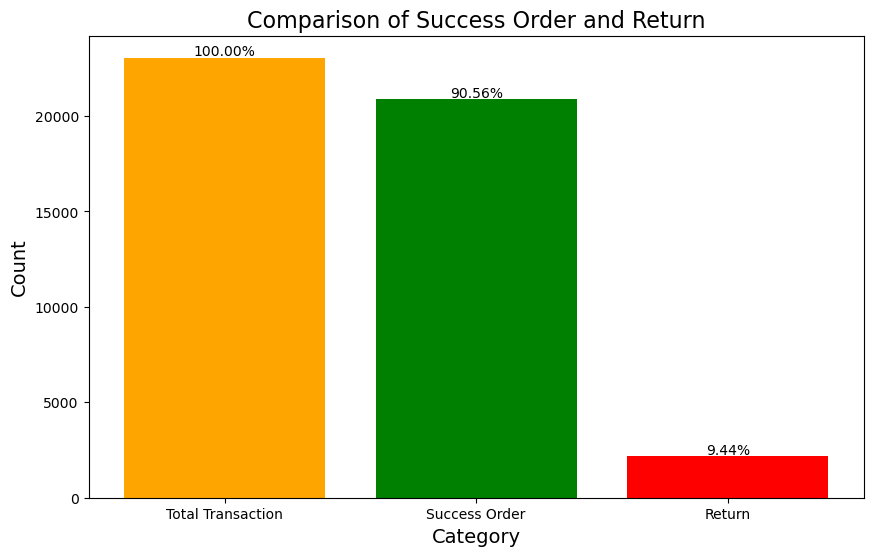

In [28]:
# Create the data
labels = ["Total Transaction", "Success Order","Return"]
values = [total_count, positive_count, negative_count]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
ax.bar(labels, values, color=['orange', 'green', 'red'])

# Add value labels on top of the bars
for i, value in enumerate(values):
    percentage = (value / total_count) * 100
    ax.annotate(f"{percentage:.2f}%", xy=(i, value - 50), ha='center', va='bottom')

# Set the title and axis labels
ax.set_title("Comparison of Success Order and Return", fontsize=16)
ax.set_xlabel("Category", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

# Show the plot
plt.show()


In [29]:
customers_df

,cust_id,DOB,Gender,city_code,Age
0,268408,1970-01-02,Male,4.0,55
1,269696,1970-01-07,Female,8.0,55
2,268159,1970-01-08,Female,8.0,55
3,270181,1970-01-10,Female,2.0,55
4,268073,1970-01-11,Male,1.0,55
...,...,...,...,...,...
5642,274474,1992-12-19,Male,2.0,32
5643,267666,1992-12-24,Male,6.0,32
5644,270476,1992-12-25,Female,3.0,32
5645,269626,1992-12-27,Female,5.0,32


## **Joining customers and transactions**

In [30]:
final_df = pd.merge(Transactions_df, customers_df, on='cust_id', how='left')
final_df.head()

,transaction_id,cust_id,tran_date,prod_sub_cat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,prod_cat,prod_subcat,prod_cat_subcat,DOB,Gender,city_code,Age
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,Clothing,Mens,Clothing Mens,1981-09-26,Male,5.0,43
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,Electronics,Computers,Electronics Computers,1973-05-11,Female,8.0,51
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,DIY,Books DIY,1992-07-27,Male,8.0,32
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,Home and kitchen,Bath,Home and kitchen Bath,1981-06-08,Male,3.0,43
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,DIY,Books DIY,1992-07-27,Male,8.0,32


In [31]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23053 entries, 0 to 23052
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_id     23053 non-null  int64         
 1   cust_id            23053 non-null  int64         
 2   tran_date          23053 non-null  object        
 3   prod_sub_cat_code  23053 non-null  int64         
 4   prod_cat_code      23053 non-null  int64         
 5   Qty                23053 non-null  int64         
 6   Rate               23053 non-null  int64         
 7   Tax                23053 non-null  float64       
 8   total_amt          23053 non-null  float64       
 9   Store_type         23053 non-null  object        
 10  prod_cat           23053 non-null  object        
 11  prod_subcat        23053 non-null  object        
 12  prod_cat_subcat    23053 non-null  object        
 13  DOB                23053 non-null  datetime64[ns]
 14  Gender

## **Removing Unwanted columns**

In [32]:
final_df=final_df.drop(columns=['transaction_id','tran_date','Rate','Tax','total_amt','DOB','prod_cat_code','prod_sub_cat_code','prod_cat','prod_subcat'])
final_df.head()

,cust_id,Qty,Store_type,prod_cat_subcat,Gender,city_code,Age
0,270351,-5,e-Shop,Clothing Mens,Male,5.0,43
1,270384,-5,e-Shop,Electronics Computers,Female,8.0,51
2,273420,-2,TeleShop,Books DIY,Male,8.0,32
3,271509,-3,e-Shop,Home and kitchen Bath,Male,3.0,43
4,273420,-2,TeleShop,Books DIY,Male,8.0,32


## **Removing Dublicate Rows**

In [33]:
duplicate_rows = final_df[final_df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

final_df = final_df.drop_duplicates()
duplicate_rows = final_df[final_df.duplicated()]
print("Duplicate Row after removing",duplicate_rows.shape[0])

final_df = final_df.reset_index(drop=True)
final_df.head()

Number of duplicate rows: 197
Duplicate Row after removing 0


,cust_id,Qty,Store_type,prod_cat_subcat,Gender,city_code,Age
0,270351,-5,e-Shop,Clothing Mens,Male,5.0,43
1,270384,-5,e-Shop,Electronics Computers,Female,8.0,51
2,273420,-2,TeleShop,Books DIY,Male,8.0,32
3,271509,-3,e-Shop,Home and kitchen Bath,Male,3.0,43
4,272357,-2,TeleShop,Electronics Personal Appliances,Female,6.0,42


## Saving the clean data to pickel file

In [34]:
final_df.to_pickle(data_path+ 'prepared_data.pkl')